***
**Adapted by**: Peter Lu \
Adapted from [here](https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb) \
CS108: Data Science Ethics (UCR - Winter 2024)
***

# Aequitas Data Ethics Library
In this notebook, we'll take a look at library that efficiently computes and visualizes data ethical metrics: `Aequitas`. We'll briefly see how to use it for both bias and fairness with respect to model predictions.

***
## Aequitas
Using Aequitas is a three-step process that requires building off of its fundamental classes: \
`Group()`: Defines groups/categories of interest \
`Bias()`: Calculates metrics and relative metrics \
`Fairness()`: Asserts fairness with respect to certain metrics

Before we utilize Aequitas, we must pre-process the data in a format Aequitas classes accept. Aequitas classes work with datasets under some assumptions:


1.   The columns are categorical variables
2.   Labels are binary and are stored in a column `label_value`
3.   A model is trained and has predicted labels in a column `score`

To work with familiar data, we'll be working with the COMPAS dataset. Let's perform some preprocessing as we saw in assignment 1!




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

%matplotlib inline


In [2]:
# Load data
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)
df_compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
# Grab useful columns
cols_to_keep = ["id", "age", "c_charge_degree", "race", "age_cat", "score_text",
                "sex", "priors_count", "days_b_screening_arrest",
                "decile_score", "is_recid", "two_year_recid"]

df_selected = df_compas[cols_to_keep].copy()


# Grab samples of interest
df_analysis = df_selected[
    (df_selected.score_text != "N/A") &
    (df_selected.days_b_screening_arrest <= 30) &
    (df_selected.days_b_screening_arrest >= -30) &
    (df_selected.is_recid != -1) &
    (df_selected.c_charge_degree != "O")
    ].copy()

df_analysis["decile_score"] = pd.to_numeric(df_analysis["decile_score"])
df_analysis.head()

,id,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid
0,1,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,3,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1
2,4,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1
5,7,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0
6,8,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1


Here, we prepare the data for model training. We'll train a logistic regression model to predict `0` for `low risk` and `1` for `medium or high risk`.

In [4]:
df_logistic = df_analysis.copy()

# one-hot encoding
df_logistic = pd.get_dummies(df_logistic,
                             columns = ["c_charge_degree", "race",
                                        "age_cat", "sex"])

# Replace 'Low' with 0 and `Medium` / `High` with 1
df_logistic["label"] = np.where(df_logistic["score_text"] != "Low", 1, 0)
df_logistic.drop(columns = ['score_text'], inplace = True)

# Format column names
df_logistic.columns = df_logistic.columns.str.replace(' ', '_')
df_logistic.columns = df_logistic.columns.str.replace('-', '_')

renamed_cols = {'age_cat_25___45':'age_cat_25_to_45',
                'c_charge_degree_F':'Felony',
                'c_charge_degree_M':'Misdemeanor'}

df_logistic = df_logistic.rename(columns = renamed_cols)
df_logistic.head()

,id,age,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,Felony,Misdemeanor,race_African_American,...,race_Caucasian,race_Hispanic,race_Native_American,race_Other,age_cat_25_to_45,age_cat_Greater_than_45,age_cat_Less_than_25,sex_Female,sex_Male,label
0,1,69,0,-1.0,1,0,0,True,False,False,...,False,False,False,True,False,True,False,False,True,0
1,3,34,0,-1.0,3,1,1,True,False,True,...,False,False,False,False,True,False,False,False,True,0
2,4,24,4,-1.0,4,1,1,True,False,True,...,False,False,False,False,False,False,True,False,True,0
5,7,44,0,0.0,1,0,0,False,True,False,...,False,False,False,True,True,False,False,False,True,0
6,8,41,14,-1.0,6,1,1,True,False,False,...,True,False,False,False,True,False,False,False,True,1


Train the logistic regression model on the same columns in the first assignment.

In [5]:
model = LogisticRegression()
X = df_logistic[['priors_count', 'two_year_recid', 'Misdemeanor', 'age_cat_Greater_than_45', 'age_cat_Less_than_25', 'race_African_American', 'race_Asian', 'race_Hispanic', 'race_Native_American', 'race_Other', 'sex_Female']].to_numpy()
y = df_logistic['label'].to_numpy()
model.fit(X, y)

LogisticRegression()

In [6]:
model.coef_

array([[ 0.26839009,  0.68385171, -0.30914112, -1.3438409 ,  1.30070711,
         0.4781718 , -0.29529593, -0.42257968,  0.84204615, -0.80596423,
         0.21808218]])

In [7]:
model.intercept_

array([-1.52362763])

In [8]:
y_pred = model.predict(X)
y_pred[:5], y[:5]

(array([0, 0, 1, 0, 1]), array([0, 0, 0, 0, 1]))

Now that we've trained a model and produced binary prediction labels, we have all the pieces we need to create a dataset that Aequitas classes can accept. Let's create a dataset that has the features of interest, a `label_value` column, and `score` column.

In [9]:
df_audit = df_analysis[['race', 'sex', 'age_cat']].copy()
df_audit['label_value'] = df_logistic['label'].copy()
df_audit['score'] = y_pred
df_audit.head()

,race,sex,age_cat,label_value,score
0,Other,Male,Greater than 45,0,0
1,African-American,Male,25 - 45,0,0
2,African-American,Male,Less than 25,0,1
5,Other,Male,25 - 45,0,0
6,Caucasian,Male,25 - 45,1,1


Plot the distributions based on categories, labels, and scores.

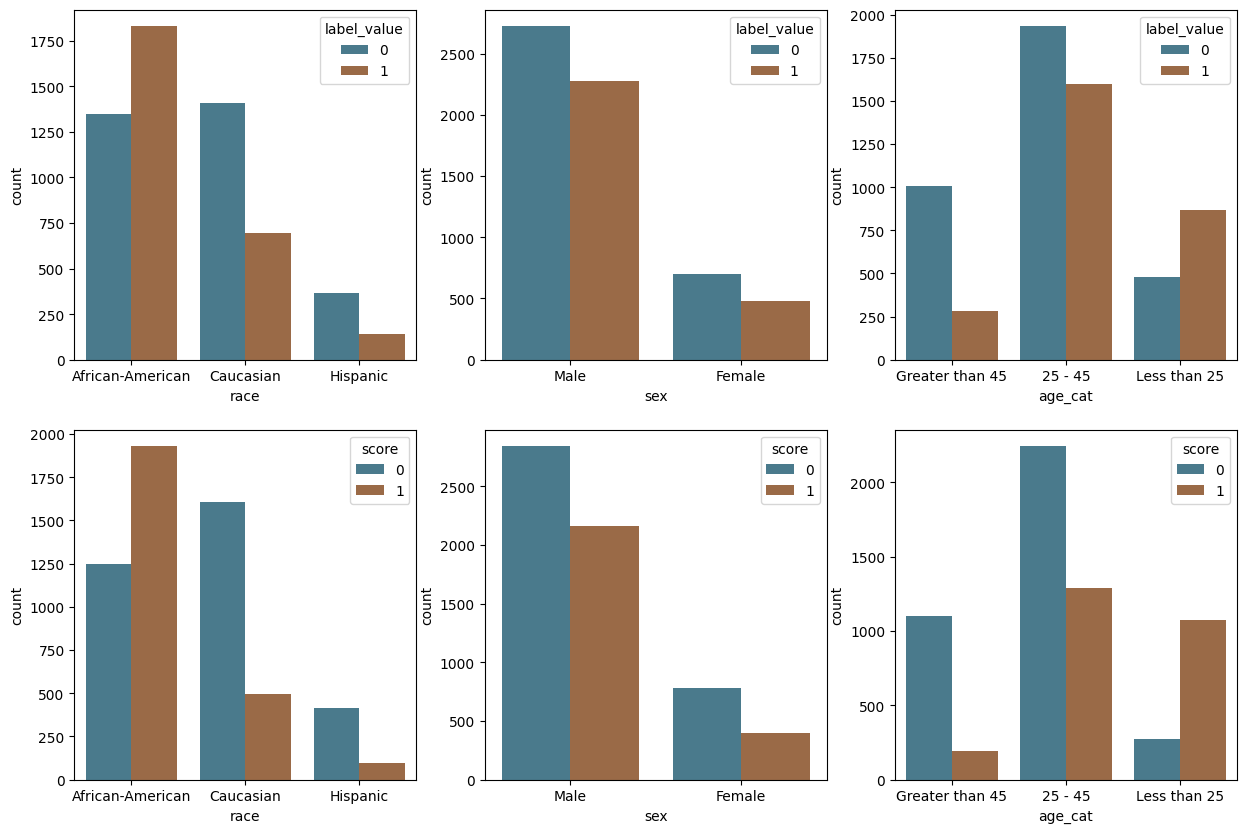

In [10]:
aq_palette = sns.diverging_palette(225, 35, n=2)

plt.figure(figsize = (15, 10))

plt.subplot(2, 3, 1)
label_by_race = sns.countplot(x="race", hue="label_value", data=df_audit[df_audit.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=aq_palette)

plt.subplot(2, 3, 2)
label_by_age = sns.countplot(x="sex", hue="label_value", data=df_audit, palette=aq_palette)

plt.subplot(2, 3, 3)
label_by_sex = sns.countplot(x="age_cat", hue="label_value", data=df_audit, palette=aq_palette)

plt.subplot(2, 3, 4)
by_race = sns.countplot(x="race", hue="score", data=df_audit[df_audit.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=aq_palette)

plt.subplot(2, 3, 5)
by_sex = sns.countplot(x="sex", hue="score", data=df_audit, palette=aq_palette)

plt.subplot(2, 3, 6)
by_age = sns.countplot(x="age_cat", hue="score", data=df_audit, palette=aq_palette)

Now that we've seen our label and score distribution across different categories in our data *and* we've formatted our data for Aequitas, let's get into it!

In [11]:
#!pip install aequitas

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of fairlearn to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/117.0 kB ? eta -:--:--
     -------------------------------------- 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ------ --------------------------------- 0.5/3.1 MB 15.9 MB/s eta 0:00:01
   ------ --------------------------------- 0.5/3.1 MB 5.4 MB/s eta 0:00:01
   -------- ------------------------------- 0.6/3.1 MB 4.5 MB/s eta 0:00:01
   ------------ --------------------------- 0.9/3.1 MB 5.4 MB/s eta 0:00:01
   ------------------ --------------------- 1.4/3.1 MB 6.0 MB/s eta 0:00:01
   ---------------------- ----------------- 1.8

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-jobspy 1.1.34 requires NUMPY==1.24.2, but you have numpy 1.23.5 which is incompatible.


In [ ]:
# Import relevant classes
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
from aequitas import Audit

***
### Group
The `Group` class allows us to cluster our data in a way Aequitas classes can efficiently use for computation of bias and fairness metrics.

In [ ]:
# Create Group object
g = Group()

# Generate crosstabs
xtab, _ = g.get_crosstabs(df_audit)

# Compute metrics
absolute_metrics = g.list_absolute_metrics(xtab)

# Displays crosstab info for confusion matrix metrics + metadata
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

In [ ]:
# Displays absolute metrics computed using confusion matrix metrics
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

***
### Plot
Aequitas's `Plot` class allows us to visualize these metrics and compare them within each of the categories in our dataset. Note that it does build off of `plt`, but the `Aequitas.plotting.Plot` methods provide the high-level functionality and labeling so that we don't need to use `plt` configurations. Assign your plots to an output variable so there is no extraneous output.

In [ ]:
# Create an Aequitas plot
aqp = Plot()

In [ ]:
# Can compare metric across categories, only displaying classes that have greater than min_group_size of our dataset
plot = aqp.plot_group_metric(xtab, 'fpr', min_group_size = 0.05)

In [ ]:
# Used to plot multiple metrics
plot = aqp.plot_group_metric_all(xtab, metrics = ['ppr', 'pprev', 'fpr'], min_group_size = 0.05, ncols = 3)

***
### Bias
Using the `Bias` class, we can compute and visualize relative metrics with respect to a reference group. In this context, "relative metric" will be referred to as "disparity." So,
$$\text{Displarity} = \frac{\text{Metric}_{\text{group}}}{\text{Metric}_{\text{ref_group}}}$$
Note that reference groups will always have a disparty of 1.

In [ ]:
# Create Bias object
bias = Bias()

# Define crosstab that contains disparities with respect to reference categories for each variable
bdf = bias.get_disparity_predefined_groups(xtab, original_df=df_audit,
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'},
                                        alpha=0.05, check_significance=True,
                                        mask_significance=True)
bdf[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bdf) + bias.list_significance(bdf)].style

Similar to the `Group` class, we can visualize information created by the `Bias` class. Here, we visualize the FPR disparity between the reference group and the other groups for race. `**` means the value is statistically significant.

In [ ]:
# Disparity plot
plot = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race', significance_alpha=0.05)

We can interpret the above visualization as saying that African Americans are 3.34 times more likely to be labeled as "high risk" than Caucasians.

In [ ]:
# Disparity plot across other categories
plot = aqp.plot_disparity_all(bdf, metrics=['fpr_disparity'], significance_alpha=0.05)

***
### Fairness
The last class of interest in our pipeline is `Fairness`. It judges if the difference in metrics between a reference group and another group are, in fact, unfair disparities. It does this by checking if a disparity falls between two threshold values (default values below):
$$0.8 < \text{Disparity} < 1.25.$$
The result of this condition is called the **parity** with respect to a metric, or metric parity. If the disparity falls between the threshold values, the model's prediction is deemed "fair" with respect to that metric. Otherwise it is deemed "unfair."

In [ ]:
# Create Fairness object
fair = Fairness()

# Define fairness crosstab
fdf = fair.get_group_value_fairness(bdf)

# Compute parities
parity_detrminations = fair.list_parities(fdf)

# Grab parities
gaf = fair.get_group_attribute_fairness(fdf)
gaf

When visualizing, we plot previously-seen visualizations. Now, plots with **green** are considered **fair** within their group and plots with **red** are considered **unfair**. Note that reference categories will **always be green** because their disparity is 1.

In [ ]:
plot = aqp.plot_fairness_group(fdf, group_metric='fpr')

In [ ]:
# Generate plots for all metrics
plot = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

In [ ]:
# Generate plots for disparity within a single category
plot = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='race')

In [ ]:
# Generate plots for disparity within a category for each metric
aqp.plot_fairness_disparity_all(fdf, attributes=['race'], metrics='all',
                                       significance_alpha=0.05)

***
### Audit
The `Audit` class provides a summary of everything we've just done. It is separate from the pipeline we've just built and does not provide the details for how it reached its conclusions, but it gives us insight into if we should do further ethical investigations into our data and model.

In [ ]:
'''
The methods we used above altered our original df_audit.
We recreate it here in its original form.
'''
df_audit = df_analysis[['race', 'sex', 'age_cat']].copy()
df_audit['label_value'] = df_logistic['label'].copy()
df_audit['score'] = y_pred

# Redefine reference groups
audit = Audit(df_audit, label_column = 'label_value', reference_groups = {'race': 'Caucasian', 'sex': 'Male', 'age_cat': '25 - 45'})
audit.audit(bias_args={
    "alpha": 0.05,
    "check_significance": True,
    "mask_significance": True
})
audit.disparity_df

In [ ]:
# Check which categories and groups pass parity tests
audit.summary_plot(metrics = ['fpr', 'fnr'], fairness_threshold = 1.25)